# Nota:
Parece que la mejor combinación es usar 
#'custom_loss':[metrics.Accuracy()] y después encontrar el threshold apropiado; de esta forma se sube el TPR hasta 0.91

In [1]:
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install seaborn
!pip install binclass-tools
!pip install catboost

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Importar librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bctools as bc

In [3]:
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, confusion_matrix

In [4]:
# Especificar columnas
relevant_columns = ['SKU','Tienda','FORMATO','Categoria','CLASE','SCLASE','DiaSem','Sem','Existencia','fiDesplazamiento','VentaPromedio','Y_Faltante']
num_columns = ['Existencia','fiDesplazamiento','VentaPromedio']
cat_columns = ['SKU','Tienda','FORMATO','Categoria','CLASE','SCLASE','DiaSem','Sem']
target = ['Y_Faltante']

In [5]:
dtype = {'SKU':'object','FORMATO':'object','REGION':'object','Tienda':'object','Categoria':'object','Proveedor':'object','CLASE':'object','SCLASE':'object','Mes':'object','DiaSem':'object','Sem':'object','Existencia':'float','fiDesplazamiento':'float',
\
'VentaPromedio':'float','Y_Faltante':'int'}

In [7]:
# Abrir el archivo
file = '1semana.csv'
data = pd.read_csv(file, header=0,low_memory=False, usecols=relevant_columns,dtype=dtype)
print('rows:', data.shape[0], ' columns:', data.shape[1])

rows: 2608114  columns: 12


In [9]:
data = data.dropna()

yes %: 6.017505470459518- no %: 93.98249452954049


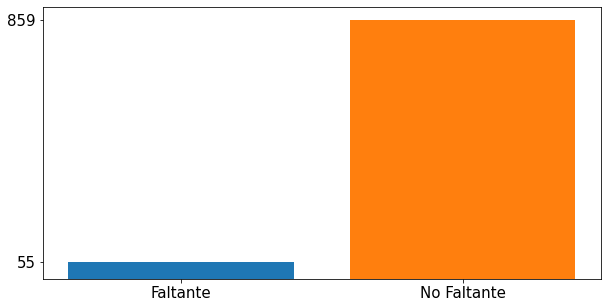

In [11]:
target = data['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))

fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


In [12]:
#Balanceamos a 50% - 50% nuestro conjunto de datos.
data_yes = data[data["Y_Faltante"] == 1]
data_no = data[data["Y_Faltante"] == 0]
over_sampling = data_yes.sample(no, replace=True, \
random_state = 0)
balanced_data = pd.concat([data_no, over_sampling], \
axis=0)
data = balanced_data.reset_index(drop=True)

yes %: 50.0- no %: 50.0


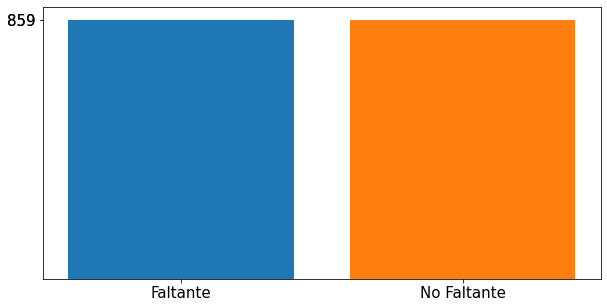

In [13]:
# Revisamos (de nuevo) la proporción de datos
target = data['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))

fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [70]:
X = data.drop('Y_Faltante',axis=1)
y = data.Y_Faltante

In [71]:
# Se construyen los conjuntos de entrenamiento y prueba sobre los que se aplicarán algoritmos de machine learning
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=0)
print('Entrenamiento:', X_train.shape[0], ' Prueba:', X_val.shape[0])

Entrenamiento: 3092  Prueba: 774


In [72]:
# Aislamos las variables numéricas y realizamos un min-max scaling sobre ellas
categorical = X_train.drop(columns=['Existencia','Desplazamiento'])
numerical = X_train[['Existencia','Desplazamiento']]
numerical_scaled = (numerical - numerical.min())/(numerical.max() - numerical.min())
X_train = pd.concat([categorical,numerical_scaled], axis=1)

In [21]:
#indices_categoricos = np.where(X_train.dtypes != float)[0]
indices_categoricos = np.where(data.dtypes != float)[0]
indices_categoricos

array([ 0,  1,  2,  3,  4,  5,  6,  7, 11])

In [22]:
#num_ind = np.where(X_train.dtypes != object)[0]
num_ind = np.where(data.dtypes != object)[0]
num_ind

array([ 8,  9, 10, 11])

Length of sequence: 10000
Best Threshold: 0.1344 with F-Score: 0.903


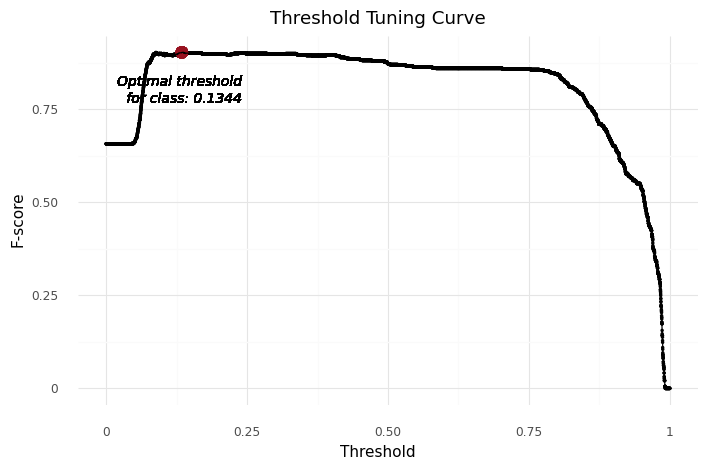

<ggplot: (8730303366126)>

In [ ]:
# Array for finding the optimal threshold
thresholds = np.arange(0.0, 1.0, 0.0001)
fscore = np.zeros(shape=(len(thresholds)))
print('Length of sequence: {}'.format(len(thresholds)))

# Fit the model
for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (y_pred_proba > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(y_val, y_pred_prob)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

# Plot the threshold tuning
df_threshold_tuning = pd.DataFrame({'F-score':fscore,
                                    'Threshold':thresholds})
df_threshold_tuning.head()

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_threshold_tuning)+
    geom_point(aes(x = 'Threshold',
                   y = 'F-score'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = thresholdOpt,
                   y = fscoreOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Threshold',
                   y = 'F-score'))+
    # Annotate the text
    geom_text(aes(x = thresholdOpt,
                  y = fscoreOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Threshold Tuning Curve')+
    xlab('Threshold')+
    ylab('F-score')+
    theme_minimal()
)

In [75]:
class LoglossMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        # approxes is a list of indexed containers
        # (containers with only __len__ and __getitem__ defined),
        # one container per approx dimension.
        # Each container contains floats.
        # weight is a one dimensional indexed container.
        # target is float.
        
        # weight parameter can be None.
        # Returns pair (error, weights sum)
        
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += -w * (target[i] * approx[i] - np.log(1 + np.exp(approx[i])))

        return error_sum, weight_sum

In [23]:
params = {
    'l2_leaf_reg':int(2.0),
    #'iterations':150,
    #'custom_loss':[metrics.Accuracy()],
    'loss_function':metrics.Logloss(),
    #'eval_metric':LoglossMetric(),
    'random_seed': 0,
    'task_type':'GPU',
    'logging_level': 'Verbose',
    'use_best_model': True,
}
catboost_pool = X_train, y_train
validate_pool = (X_val, y_val)

In [26]:
params_with_snapshot = params.copy()

model = CatBoostClassifier(**params_with_snapshot)
model.fit(X_train,y_train,cat_features=indices_categoricos, eval_set=(X_val,y_val),logging_level='Verbose',save_snapshot=True,plot=True)

print('Simple model tree count: {}'.format(model.tree_count_))
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_val, model.predict(X_val))
))
print('')

CatBoostError: Invalid cat_features[8] = 11 value: index must be < 11.

In [82]:
#model.save_model('Ago_model_medio.dump')
#model = CatBoostClassifier()
#model.load_model('Ago_model_medio.dump');

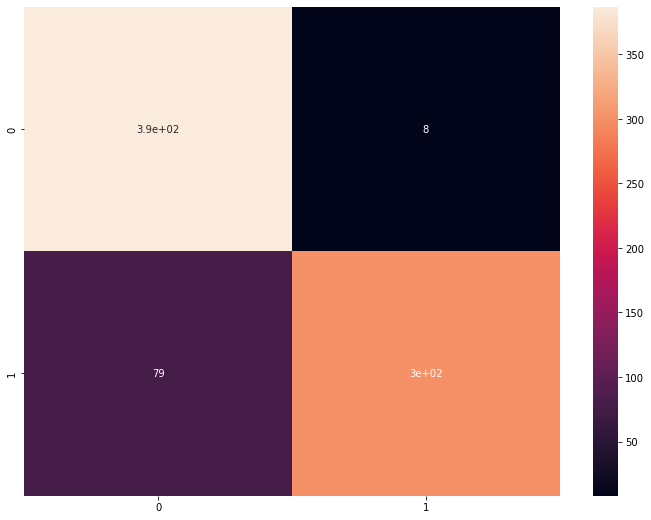

In [83]:
y_pred = model.predict(X_val)
# Dibujamos también la matriz de confusión para nuestro modelo
mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [84]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
tn,fp,fn,tp

(387, 8, 79, 300)

In [85]:
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred,average='binary',pos_label=1)
precision = precision_score(y_val,y_pred,average='binary',pos_label=0)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred,pos_label=1)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.8875968992248062
True Positive Rate 0.7915567282321899
Precision 0.8304721030042919
Balanced accuracy 0.885651781837614
f1 score 0.8733624454148472


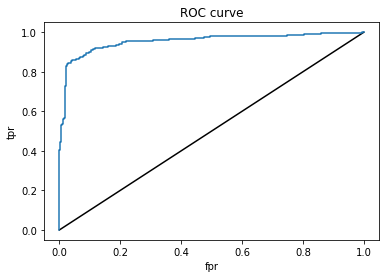

In [86]:
# Dibujamos la curva de ROC para este modelo
from sklearn.metrics import roc_curve
y_pred_proba = model.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba,pos_label=1)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [87]:
# Get prediction probabilities for the train set
train_predicted_proba = model.predict_proba(X_train)[:,1]

# Get prediction probabilities for the test set
test_predicted_proba = model.predict_proba(X_val)[:,1] 

In [88]:
area_under_ROC = bc.curve_ROC_plot(true_y= y_val, 
                                   predicted_proba = test_predicted_proba)

In [89]:
area_under_ROC

0.9545172171938145

In [105]:
# Create the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [91]:
area_under_PR = bc.curve_PR_plot(true_y= y_val, 
                                 predicted_proba = test_predicted_proba, 
                                 beta = 1)

In [92]:
area_under_PR

0.9613231508948628

In [93]:
threshold_step = 0.05

bc.predicted_proba_violin_plot(true_y = y_val, 
                               predicted_proba = test_predicted_proba, 
                               threshold_step = threshold_step)

In [94]:
# for example, if we want the True Positive data points with a 0.7 threshold:
confusion_category = 'TP'

bc.get_confusion_category_observations_df(
    confusion_category = confusion_category, 
    X_data = X_val, 
    true_y = y_val, 
    predicted_proba = test_predicted_proba, 
    threshold = 0.7 # default = 0.5
)

,SKU,Tienda,FORMATO,Categoria,CLASE,SCLASE,DiaSem,Sem,Existencia,Desplazamiento
2553,3515656,30,2,1010006007,6,7,1,7,-4799.0,6863
2713,3441662,102,3,1009013003,13,3,3,7,0.0,150
2812,3042560,612,7,1003004001,4,1,5,6,0.0,0
2455,3476213,10,3,1002001003,1,3,1,5,0.0,629
2896,3101041,7,3,2008002002,2,1,7,5,36.0,61
...,...,...,...,...,...,...,...,...,...,...
2166,3441662,102,3,1009013003,13,3,3,7,0.0,150
3437,3062503,76,3,1009004004,4,4,6,6,0.0,47
2585,3002309,253,4,1009006002,6,2,3,7,0.0,513
2653,3586158,650,7,1002003009,3,9,2,6,0.0,4


In [95]:
confusion_matrix(y_val,y_pred)

array([[387,   8],
       [ 79, 300]])

In [96]:
matthews_corrcoef(y_val,y_pred)

0.7877259890236655

# Buscamos un threshold apropido                                                   

In [97]:
# Import module for data visualization
!pip install plotnine
import plotnine
from plotnine import *

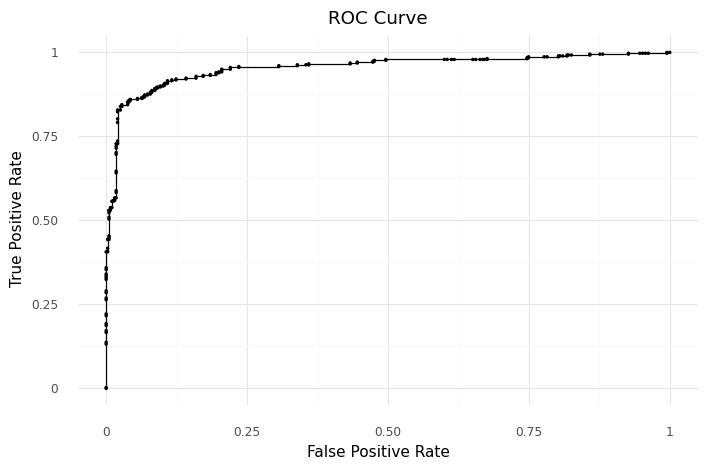

<ggplot: (8730414621956)>

In [98]:
# Create the ROC curve
y_pred_proba = model.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

# Create the data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

Best Threshold: 0.1374 with G-Mean: 0.9073
FPR: 0.043, TPR: 0.8602


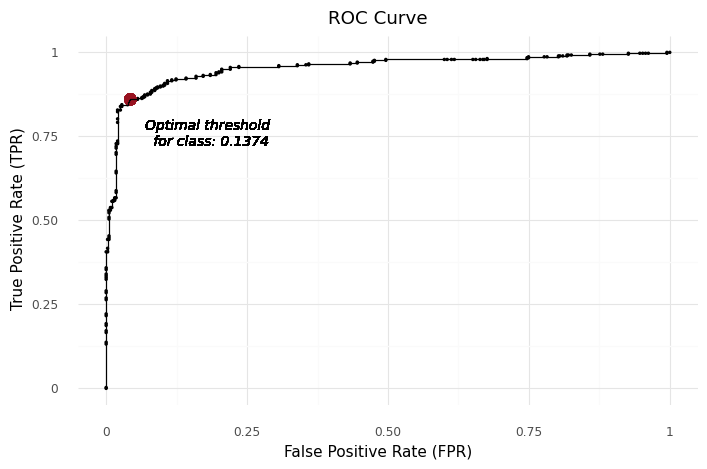

<ggplot: (8730355786530)>

In [99]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)


Best Threshold: 0.1374 with G-Mean: 0.9073
FPR: 0.043, TPR: 0.8602


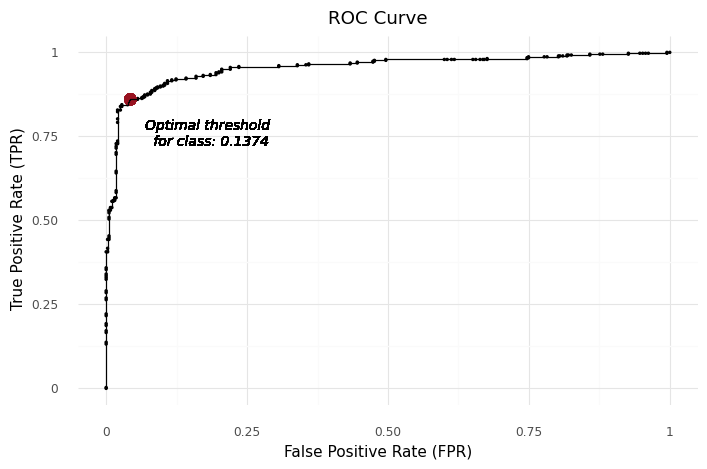

<ggplot: (8730303337454)>

In [100]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Best Threshold: 0.1374 with Youden J statistic: 0.9073
FPR: 0.043, TPR: 0.8602


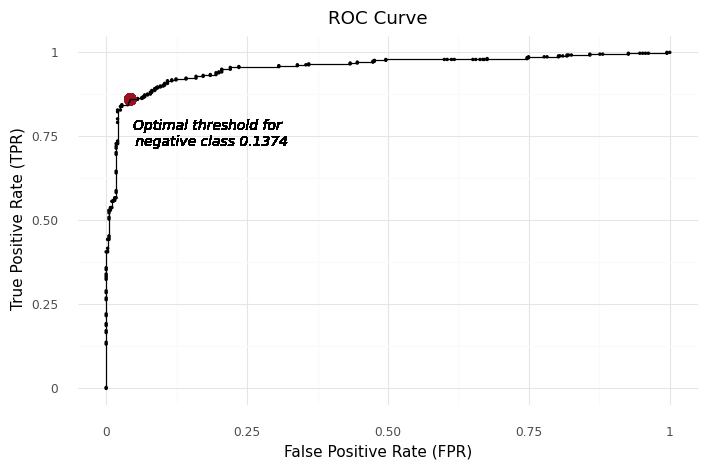

<ggplot: (8730355840016)>

In [101]:
# Calculate the Youden's J statistic
youdenJ = tpr - fpr

# Find the optimal threshold
index = np.argmax(youdenJ)
thresholdOpt = round(thresholds[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    # Annotate the text
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold for \n negative class {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

# Precision-Recall curve

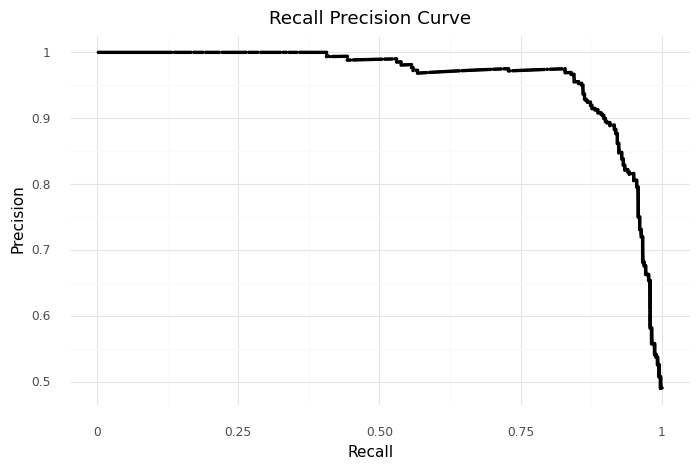

<ggplot: (8730312773873)>

In [114]:
# Create the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Plot the ROC curve
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})
df_recall_precision.head()

# Creat a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Best Threshold: 0.1374 with F-Score: 0.903
Recall: 0.8602, Precision: 0.9504


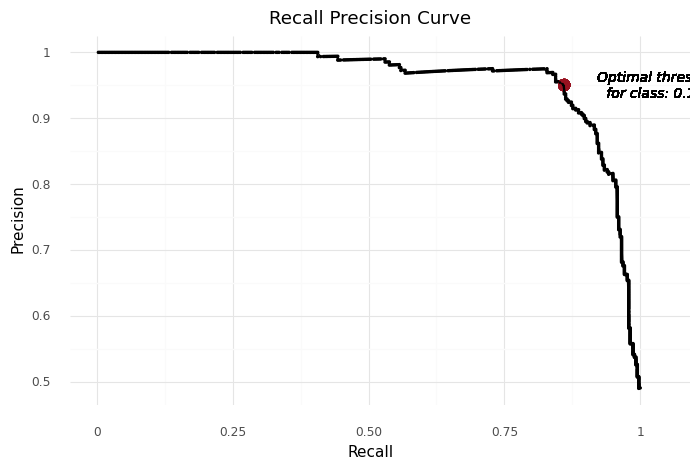

<ggplot: (8730317015179)>

In [115]:
# Calculate the f-score
fscore = (2 * precision * recall) / (precision + recall)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # Annotate the text
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

# Threshold tuning

Length of sequence: 10000
Best Threshold: 0.1344 with F-Score: 0.903


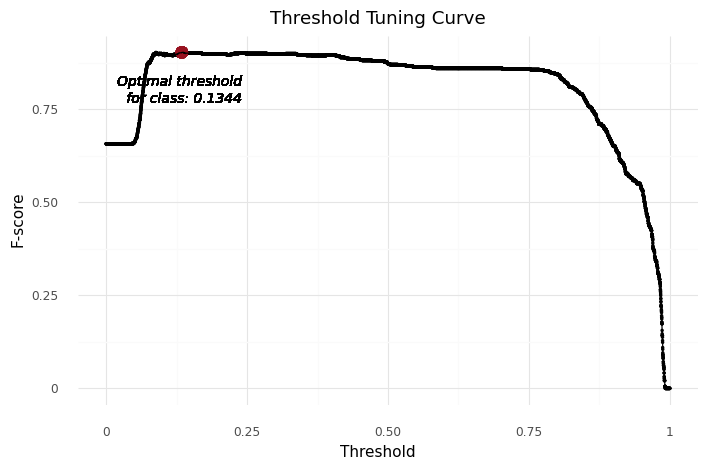

<ggplot: (8730303366126)>

In [118]:
# Array for finding the optimal threshold
thresholds = np.arange(0.0, 1.0, 0.0001)
fscore = np.zeros(shape=(len(thresholds)))
print('Length of sequence: {}'.format(len(thresholds)))

# Fit the model
for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (y_pred_proba > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(y_val, y_pred_prob)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

# Plot the threshold tuning
df_threshold_tuning = pd.DataFrame({'F-score':fscore,
                                    'Threshold':thresholds})
df_threshold_tuning.head()

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_threshold_tuning)+
    geom_point(aes(x = 'Threshold',
                   y = 'F-score'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = thresholdOpt,
                   y = fscoreOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Threshold',
                   y = 'F-score'))+
    # Annotate the text
    geom_text(aes(x = thresholdOpt,
                  y = fscoreOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Threshold Tuning Curve')+
    xlab('Threshold')+
    ylab('F-score')+
    theme_minimal()
)